In [1]:
import glob
import matplotlib.pyplot as plt
from pydicom import dcmread
from PIL import Image
import re
from skimage.restoration import denoise_wavelet
from skimage import img_as_float
from skimage.restoration import denoise_tv_chambolle
from matplotlib import pyplot as plt
from skimage import io
from skimage.metrics import peak_signal_noise_ratio
from pydicom.dataset import FileDataset, FileMetaDataset
from sklearn.metrics import mean_squared_error
import datetime
import os
import tempfile
import pydicom
from pydicom.dataset import FileDataset, FileMetaDataset
from pydicom.uid import UID
import nibabel as nib
import numpy as np
import scipy.ndimage as ndi

print("Hello")

files = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/1-2 dose/*.IMA")
print(len(files))

dose12 = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/1-2 dose/*.IMA")
dose1100 = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/1-100 dose/*.IMA")

ref_files = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/*/Full_dose/*.IMA")
print(len(ref_files))

print(dose1100[868])
print(ref_files[868])

ModuleNotFoundError: No module named 'pydicom'

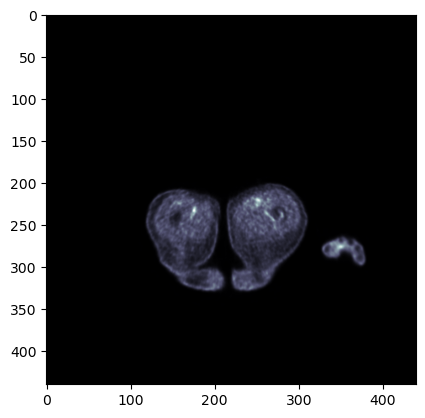

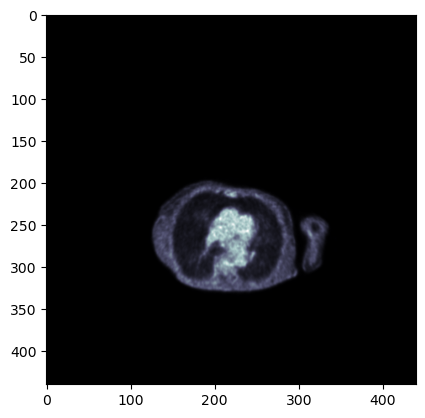

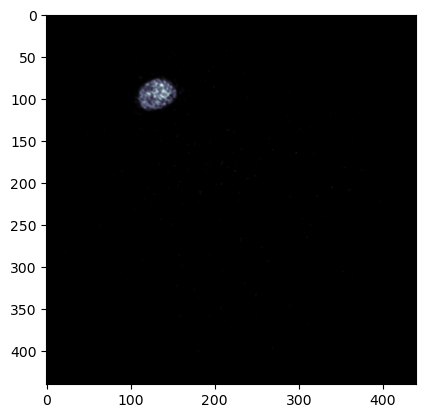

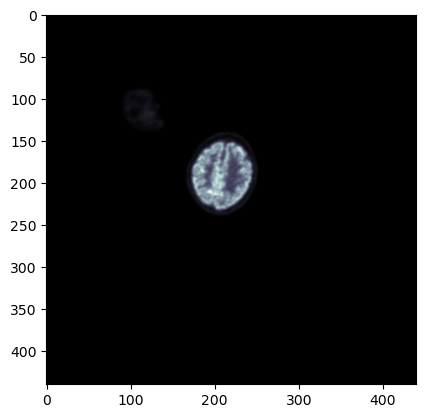

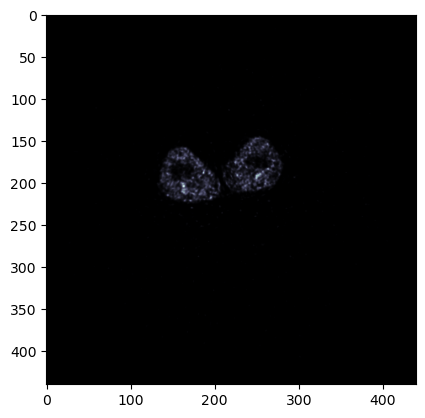

X_data shape: (3864, 440, 440)


In [63]:


def show_img(img_path):
    ds = dcmread(img_path)
    im = Image.fromarray(ds.pixel_array)
    #im = im.resize((DESIRED_SIZE,DESIRED_SIZE)) 
    #im.show()
    plt.imshow(im, cmap=plt.cm.bone)
    plt.show()
    



#dose1100.sort(key=lambda f: int(re.sub('\D', '', f)))
#dose1100

#ref_files.sort(key=lambda f: int(re.sub('\D', '', f)))

noisy_img = img_as_float(io.imread(files[6]))
ref_img = img_as_float(io.imread(ref_files[6]))
show_img(files[5])
show_img(files[4])
show_img(files[3])
show_img(files[2])
show_img(files[1])


X_data = []

for my_file in files:
    #print(my_file)
    X_data.append(img_as_float(io.imread(my_file)))

print('X_data shape:', np.array(X_data).shape)

In [64]:

wavelet_smoothed = denoise_wavelet(X_data[0], multichannel=False,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True,wavelet='db2')

#denoise_TV = denoise_tv_chambolle(noisy_img, weight=0.7, multichannel=False)
denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=0.7, multichannel=False)

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/3232294619.py:1: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(X_data[0], multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/3232294619.py:6: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=0.7, multichannel=False)


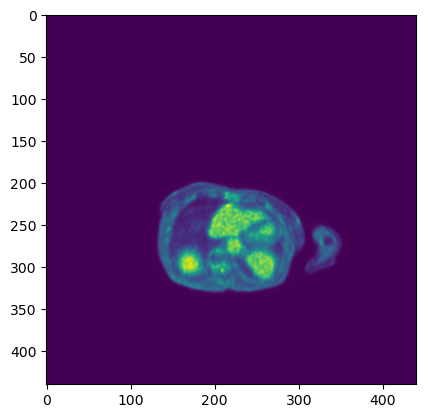

In [65]:
plt.imshow(ref_img)

PSNR of input noisy image =  -49.26556065175823
PSNR of cleaned image =  -54.494874730154244
MSE: 281505.9


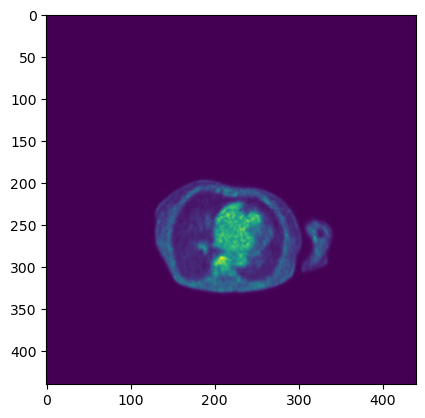

In [66]:
noise_psnr = peak_signal_noise_ratio(ref_img, noisy_img, data_range=1.0)
TV_cleaned_psnr = peak_signal_noise_ratio(ref_img, denoise_TV, data_range=1.0)
print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", TV_cleaned_psnr)


mse_tv = mean_squared_error(denoise_TV, ref_img)
print("MSE:",mse_tv)
plt.imshow(noisy_img)

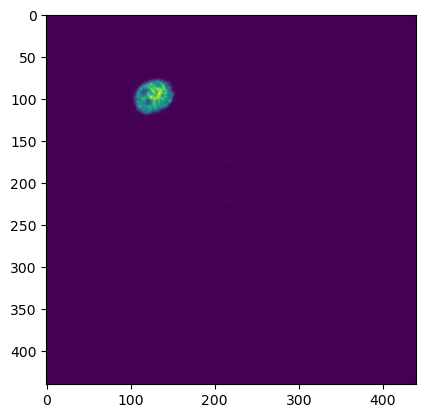

In [67]:
plt.imshow(denoise_TV)



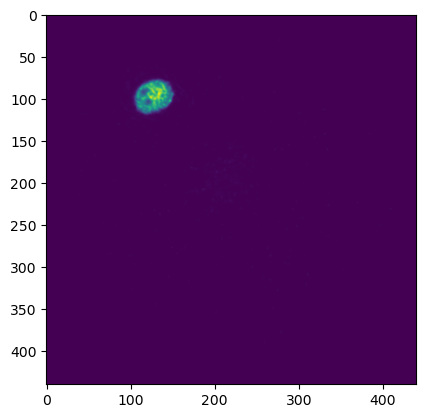

In [68]:
plt.imshow(wavelet_smoothed)

(440, 440)
PSNR of input noisy image =  -49.26671666866145
MSE: 84464.00431938058
MSE: 0.8317102486257347
MSE: 84441.52


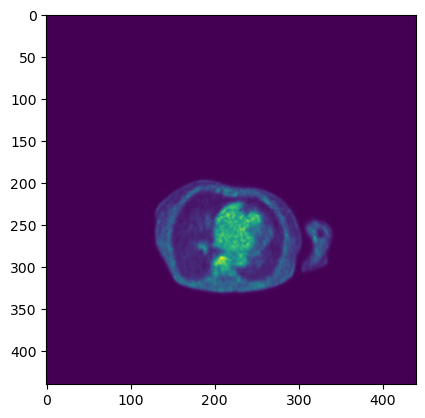

In [69]:
#print(denoise_TV)

print(noisy_img.shape)

u, s, vh = np.linalg.svd(noisy_img, full_matrices=False)

s_cleaned = np.array([si if si > 100 else 0 for si in s])
#s_cleaned =s
# Calculate A' = U * Σ (cleaned) * V
img_denoised = np.array(np.dot(u * s_cleaned, vh), dtype=int)



noise_psnr = peak_signal_noise_ratio(ref_img, img_denoised, data_range=1.0)
print("PSNR of input noisy image = ", noise_psnr)



mse_ref = mean_squared_error(img_denoised, ref_img)
mse_noisy = mean_squared_error(img_denoised, noisy_img)
mse_noisy_ref = mean_squared_error(ref_img, noisy_img)
print("MSE:",mse_ref)
print("MSE:",mse_noisy)
print("MSE:",mse_noisy_ref)

plt.imshow(noisy_img)


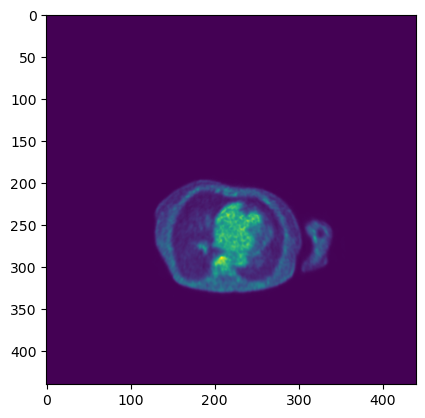

In [70]:
plt.imshow(img_denoised)


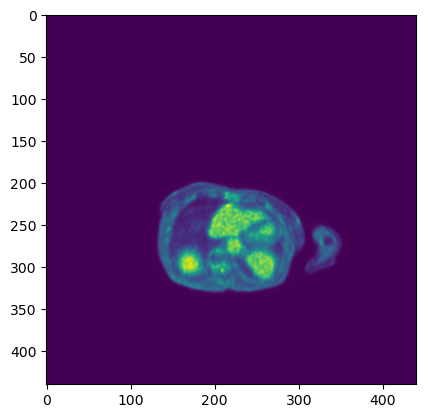

In [71]:
plt.imshow(ref_img)

In [72]:
# Create some temporary filenames
suffix = '.IMA'
filename_little_endian = tempfile.NamedTemporaryFile(suffix=suffix).name
filename_big_endian = tempfile.NamedTemporaryFile(suffix=suffix).name

print("Setting file meta information...")
# Populate required values for file meta information
file_meta = FileMetaDataset()
file_meta.MediaStorageSOPClassUID = UID('1.2.840.10008.5.1.4.1.1.2')
file_meta.MediaStorageSOPInstanceUID = UID("1.2.3")
file_meta.ImplementationClassUID = UID("1.2.3.4")

print("Setting dataset values...")
# Create the FileDataset instance (initially no data elements, but file_meta
# supplied)
ds = FileDataset(filename_little_endian, {},
                 file_meta=file_meta, preamble=b"\0" * 128)

# Add the data elements -- not trying to set all required here. Check DICOM
# standard
ds.PatientName = "Test^Firstname"
ds.PatientID = "123456"

# Set the transfer syntax
ds.is_little_endian = True
ds.is_implicit_VR = True

# Set creation date/time
dt = datetime.datetime.now()
ds.ContentDate = dt.strftime('%Y%m%d')
timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
ds.ContentTime = timeStr

ds.PixelData = denoise_TV.tobytes()
print("Writing test file", filename_little_endian)
ds.save_as(filename_little_endian)
print("File saved.")

# Write as a different transfer syntax XXX shouldn't need this but pydicom
# 0.9.5 bug not recognizing transfer syntax
ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRBigEndian
ds.is_little_endian = False
ds.is_implicit_VR = False

print("Writing test file as Big Endian Explicit VR", filename_big_endian)
ds.save_as(filename_big_endian)

# reopen the data just for checking
for filename in (filename_little_endian, filename_big_endian):
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)
    print(ds)

    # remove the created file
    print('Remove file {} ...'.format(filename))
   # os.remove(filename)

Setting file meta information...
Setting dataset values...
Writing test file /var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/tmp87i6042w.IMA
File saved.
Writing test file as Big Endian Explicit VR /var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/tmpwsm5o1w1.IMA
Load file /var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/tmp87i6042w.IMA ...
Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.3
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
-------------------------------------------------
(0008, 0023) Content Date                        DA: '20221030'
(0008, 0033) Content Time                        TM: '075327.867728'
(0010, 0010) Patient's Name                      PN: 'Test^Firstname'
(0010, 0020) Patient ID                          LO: '123456'
(7fe0, 0010) Pixel Data                          OW: Array of 774400 elements
Remove file /var/folders/

In [73]:
files = glob.glob("/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/tmpqeyj_8rq.IMA")
files

print(files)




[]


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 440 440 644   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.   1.65 1.65 1.65 1.   1.   1.   1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 363.776
qoffset_y       : 501.154
qoffset_z       : -1060.95
srow_x          : [ -1.65 

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/3737079472.py:18: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(img_data[i], multichannel=False,
/Users/randyllpandohie/opt/anaconda3/envs/tensorflow_py/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/randyllpandohie/opt/anaconda3/envs/tensorflow_py/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/3737079472.py:21: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wave

PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of in

PSNR of input noisy image =  -48.45975762362463
PSNR of input noisy image =  -48.700966114312756
PSNR of input noisy image =  -49.12585391128324
PSNR of input noisy image =  -48.81565466640847
PSNR of input noisy image =  -48.63851430214268
PSNR of input noisy image =  -48.827697747052945
PSNR of input noisy image =  -48.849163073171255
PSNR of input noisy image =  -49.374539381590594
PSNR of input noisy image =  -49.41322255572209
PSNR of input noisy image =  -49.142396800541555
PSNR of input noisy image =  -48.747181094145944
PSNR of input noisy image =  -49.014880026484704
PSNR of input noisy image =  -48.93133311404088
PSNR of input noisy image =  -49.18272901213616
PSNR of input noisy image =  -49.32595132602631
PSNR of input noisy image =  -49.38101165211058
PSNR of input noisy image =  -50.18740880275899
PSNR of input noisy image =  -49.97915009666241
PSNR of input noisy image =  -49.688343960835
PSNR of input noisy image =  -49.607087606387154
PSNR of input noisy image =  -50.0

PSNR of input noisy image =  3.309302794244686
PSNR of input noisy image =  11.833401427696053
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input noisy image =  nan
PSNR of input 

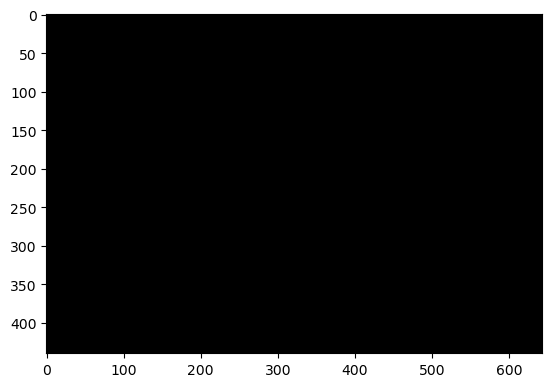

In [74]:
all_images=glob.glob('/Users/randyllpandohie/Downloads/testing/*.nii.gz')



test_image=nib.load(all_images[0])

print(test_image.header)

print(test_image.get_fdata().shape)


img_data = test_image.get_fdata()
plt.imshow(img_data[400])

for i in range(len(img_data[:])):
   # print(i)
   # img_data[i]
    wavelet_smoothed = denoise_wavelet(img_data[i], multichannel=False,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True,wavelet='db2')
    denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=0.7, multichannel=False)
    u, s, v = np.linalg.svd(img_data[i], full_matrices=False)
    low_rank = u[:, :20] @ np.diag(s[:20]) @ v[:20, :]
    plt.imshow(low_rank, cmap='gray')
    #noise_psnr = peak_signal_noise_ratio(img_data[i], denoise_TV, data_range=1.0)
    noise_psnr = peak_signal_noise_ratio(low_rank, denoise_TV, data_range=1.0)
    print("PSNR of input noisy image = ", noise_psnr)
    img_data[i]=denoise_TV
    #img_data.update(i, denoise_TV)
    
   
img = nib.Nifti1Image(img_data, test_image.affine)

img.get_data_dtype() == np.dtype(np.int16)

img.header.get_xyzt_units()

nib.save(img, os.path.join('./build', 'new_improved.nii.gz'))  



# Test and exporting

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/1986441653.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  test_image=nib.load(all_images[0]).get_data()


(440, 644)


/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/1986441653.py:15: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(slices, multichannel=False,
/Users/randyllpandohie/opt/anaconda3/envs/tensorflow_py/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/1986441653.py:18: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=0.7, multichannel=False)


(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)
(440, 644)

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/1986441653.py:26: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  wavelet_smoothed = denoise_wavelet(noisy_img, multichannel=False,
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/1986441653.py:31: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=0.7, multichannel=False)


PSNR of input noisy image =  -49.26671666866145
PSNR of input noisy image =  4.84969899620915
PSNR of cleaned image =  4.84969899620915


NameError: name 'brain_vol_data' is not defined

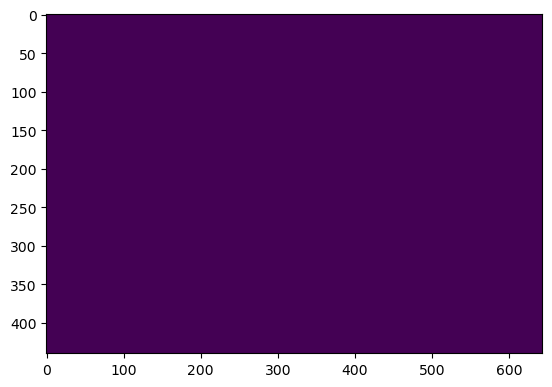

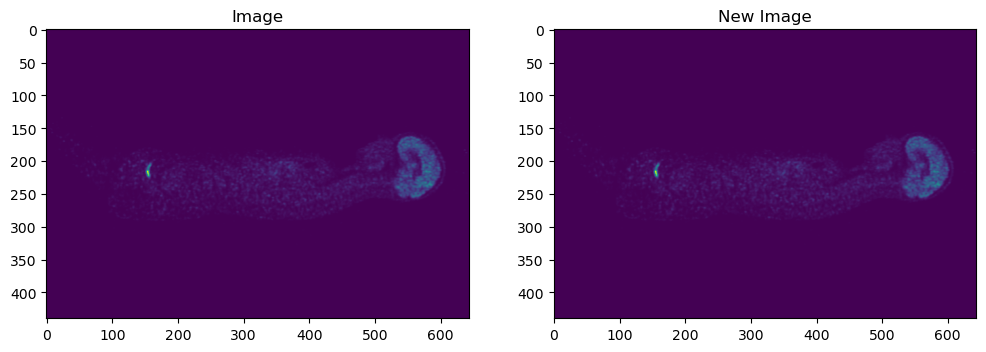

In [75]:
all_images=glob.glob('/Users/randyllpandohie/Downloads/testing/*.nii.gz')




test_image=nib.load(all_images[0]).get_data()


plt.imshow(x_slice)


    
for slices in test_image:
    print(slices.shape)
    wavelet_smoothed = denoise_wavelet(slices, multichannel=False,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True,wavelet='db2')
    denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=0.7, multichannel=False)


noisy_img = test_image
#noisy_img = img_as_float(test_image) 



wavelet_smoothed = denoise_wavelet(noisy_img, multichannel=False,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True,wavelet='db2')

#denoise_TV = denoise_tv_chambolle(noisy_img, weight=0.7, multichannel=False)
denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=0.7, multichannel=False)



#u, s, vh = np.linalg.svd(noisy_img, full_matrices=False)

#s_cleaned = np.array([si if si > 250 else 0 for si in s])
#s[s>250]=0
# Calculate A' = U * Σ (cleaned) * V
#img_denoised = np.array(np.dot(u * s_cleaned, vh), dtype=int)

#img_denoised = np.array(np.dot(u * s, vh), dtype=int)

noise_psnr = peak_signal_noise_ratio(ref_img, img_denoised, data_range=1.0)
print("PSNR of input noisy image = ", noise_psnr)


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(test_image[test_image.shape[0]//2])
ax1.set_title('Image')
ax2.imshow( denoise_TV[denoise_TV.shape[0]//2])
ax2.set_title('New Image')


noise_psnr = peak_signal_noise_ratio(noisy_img, denoise_TV, data_range=1.0)
TV_cleaned_psnr = peak_signal_noise_ratio(noisy_img, denoise_TV, data_range=1.0)
print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", TV_cleaned_psnr)


img = nib.Nifti1Image(denoise_TV, np.eye(4))
img.get_data_dtype() == np.dtype(np.int16)

img.header.get_xyzt_units()

nib.save(img, os.path.join('./build', 'test4d.nii.gz'))  



fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[img, :, :], 90))
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()


In [ ]:
# Load image
#plt.imread("../assets/images/svd-data-compression/cameraman.png")
#print(ref_files[1])

img = noisy_img
plt.imshow(img[img.shape[0]//2])

# Donwsample and encode RGBa image as matrix of intensities, X
DOWNSAMPLE = 4
R = img[::DOWNSAMPLE, ::DOWNSAMPLE, 0]
G = img[::DOWNSAMPLE, ::DOWNSAMPLE, 1]
B = img[::DOWNSAMPLE, ::DOWNSAMPLE, 2] 
X = 0.2989 * R + 0.5870 * G + 0.1140 * B
#X =  R +  G +  B
print(img)
print(X)
X = img
# Calculate the rank of the data matrix, X
img_rank = np.linalg.matrix_rank(X, 0.)
print(img_rank)

# Run SVD on Image
U, S, V = np.linalg.svd(X)

# Calculate the cumulative variance explained by each singular value
total_S = S.sum()
n_components = len(S)
component_idx = range(1,  n_components + 1)
info_retained = 100 * np.cumsum(S) / total_S

# Visualizations
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

## Raw Image, X
plt.sca(axs[0])
plt.imshow(X[X.shape[0]//2])
#plt.imshow(X, cmap='gray')
plt.title(f"Matrix $X$ encoding a Grayscale Image\n(Rank, $r=${img_rank})")

## Singular values as function of rank
plt.sca(axs[1])

### Raw singular values
plt.plot(component_idx, S, label='Singular Values of $$X$$', color='darkblue', linewidth=3)
plt.grid()
plt.xlabel("Rank, $k$")
plt.ylabel('$S_k$', color='darkblue')
plt.tick_params(axis='y', labelcolor='darkblue')
plt.title('Singular Values, $S_k$')

### log(singular values)
twax = plt.gca().twinx()  # twin axes that shares the same x-axis
twax.plot(component_idx, np.log(S), color='red', linewidth=3)
plt.ylabel('$\log(S_k)$\n', color='red', rotation=270)
plt.tick_params(axis='y', labelcolor='red')
plt.ylim([-6, 6])

## Information retained as function of rank
plt.sca(axs[2])
plt.plot(component_idx, info_retained, color='darkgreen', linewidth=3)
plt.xlim(0, n_components)
plt.ylim([0, 105])
plt.xlabel("Rank, $k$")
plt.grid()
plt.title('Cumulative % of Information About $X$\nCarried by Singular Vectors')


In [ ]:
## Image Reconstruction
N = 5
fig, axs = plt.subplots(N, 4, figsize=(10, 16))
plt.sca(axs[0][0])
#plt.imshow(X, cmap='gray')
plt.imshow(X[X.shape[0]//2])
plt.clim([0, 1.])
plt.axis('off')
plt.title("$X$", fontsize=14)

# Reconstruct image with increasing number of singular vectors/values
for power in range(1, N + 1):
    rank = 2 ** (1 + power)

    # Compressed/Reconstructed Image
    X_reconstruction = U[:, :rank] * S[:rank] @ V[:rank,:]

    # Calculate number of floats required to store compressed image
    rank_data_compression = 100 * (1. - (1. * U[:, :rank].size + S[:rank].size + V[:rank,:].size) / X.size)

    # Variance of original image explained by n components
    rank_info_retained = info_retained[rank-1]

    # Visualizations
    ## Original Image
    if power > 1:
        plt.sca(axs[power-1][0])
        plt.cla()
        plt.axis('off')

    ## Image reconstruction
    plt.sca(axs[power-1][1])
    #plt.imshow(X_reconstruction, cmap='gray')
    plt.imshow(X_reconstruction)
    plt.clim([0, 1.])
    plt.axis('off')
    plt.title(f'dds', fontsize=14)

    ## Reconstruction error
    plt.sca(axs[power-1][2])
    cax = plt.imshow(X - X_reconstruction)
    plt.clim([-.5, .5])
    plt.axis('off')
    plt.title(f'fdd', fontsize=14)

    ## Compression/reconstruction info
    plt.sca(axs[power-1][3])
    compression_text = f'Compression: {rank_data_compression:1.1f}%\nInfo. Retained {rank_info_retained:1.1f}%'
    plt.text(-.1, .4, compression_text)
    plt.axis('off')
    
fig.colorbar(cax, ax=axs[0][2], pad=.01, orientation='horizontal')

In [ ]:
plt.imshow(X_reconstruction)

/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/2611042761.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  test_image=nib.load(all_images[1]).get_data()
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/2611042761.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  test_image1=nib.load(all_images[2]).get_data()
/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/ipykernel_37117/2611042761.py:13: DeprecationWarning: get_data() is de

Text(0.5, 1.0, 'Full Dose')

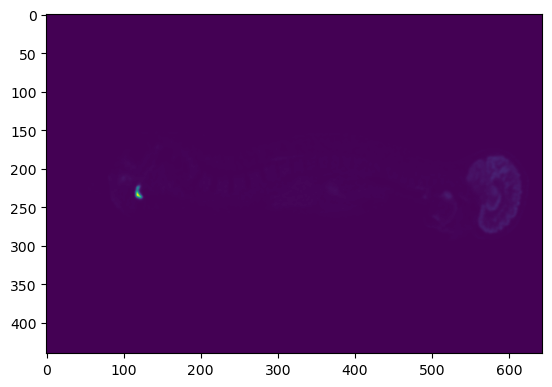

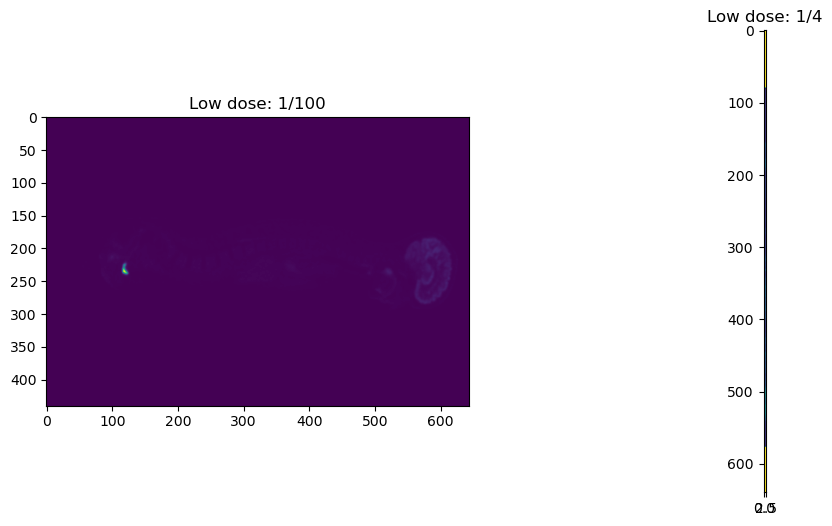

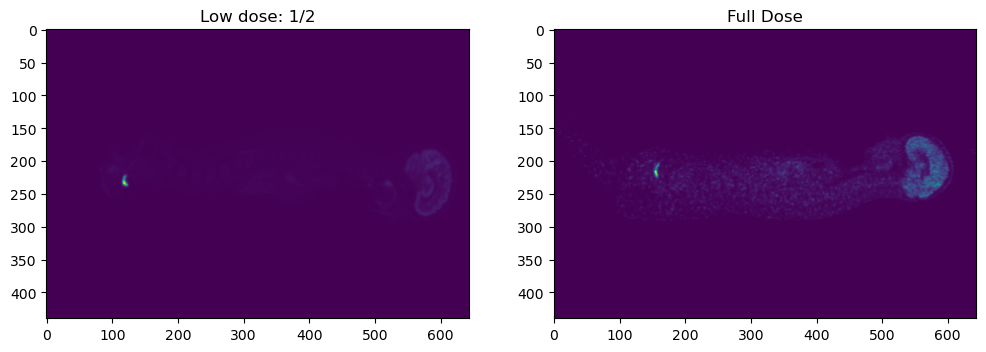

In [79]:
import dicom2nifti


dicom2nifti.convert_directory("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/1-4 dose/", "./build/", compression=True, reorient=True)
dicom2nifti.convert_directory("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/Full_dose/", "./build/", compression=True, reorient=True)
all_images=glob.glob('./build/*.nii.gz')




test_image=nib.load(all_images[1]).get_data()
test_image1=nib.load(all_images[2]).get_data()
test_image2=nib.load(all_images[0]).get_data()
test_image3=nib.load(all_images[3]).get_data()
plt.imshow(test_image[test_image.shape[0]//2])


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(test_image[test_image.shape[0]//2])
ax1.set_title('Low dose: 1/100')
ax2.imshow( test_image1[test_image1.shape[0]//2])
ax2.set_title('Low dose: 1/4')
fig, (ax3, ax4) = plt.subplots(1,2, figsize = (12, 6))
ax3.imshow( test_image3[test_image3.shape[0]//2])
ax3.set_title('Low dose: 1/2')
ax4.imshow( test_image2[test_image2.shape[0]//2])
ax4.set_title('Full Dose')

['./data/test/190722_03_20220720_145655/new4d.nii.gz']


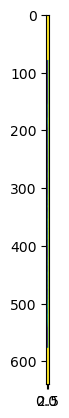

In [8]:
all_images=glob.glob('./data/test/190722_03_20220720_145655/*.nii.gz')
print(all_images)
test_image=nib.load(all_images[0]).get_fdata()

plt.imshow(test_image[test_image.shape[0]//2])

In [98]:
all_images=glob.glob('./data/test/*/*.nii.gz')
files = [os.path.basename(x) for x in all_images]
#path = [os.path.relpath(x) for x in all_images]
path = [os.path.dirname(x) for x in all_images]


filtered = [fn for fn in all_images 
         if not os.path.basename(fn).startswith('new')]

print(filtered)

for i in range(len(all_images)):
    new_path = os.path.join(path[i], "new"+files[i])
    print(new_path)

#print(files)
#print(path)


['./data/test/Anonymous_ANO_20220908_1400086_102404/DRF_4.nii.gz', './data/test/040822_2_20220804_164736/DRF_10.nii.gz', './data/test/Anonymous_ANO_20220908_1401565_101224/DRF_10.nii.gz', './data/test/Anonymous_ANO_20220809_1802192_095347/DRF.nii.gz', './data/test/Anonymous_ANO_20220926_1506119_130326/DRF.nii.gz', './data/test/Anonymous_ANO_20220809_1803263_085417/DRF.nii.gz', './data/test/Anonymous_ANO_20220908_1425413_114222/DRF_20.nii.gz', './data/test/200722_01_20220720_145903/DRF_4.nii.gz', './data/test/Anonymous_ANO_20220926_1504021_100007/DRF.nii.gz', './data/test/280722_3_20220728_164155/DRF_50.nii.gz', './data/test/Anonymous_ANO_20220908_1427414_113157/DRF_50.nii.gz', './data/test/Anonymous_ANO_20220908_1358182_110521/DRF_100.nii.gz', './data/test/Anonymous_ANO_20220908_1356283_111607/DRF_4.nii.gz', './data/test/Anonymous_ANO_20220824_1307046_111435/DRF.nii.gz', './data/test/280722_1_20220728_164024/DRF_10.nii.gz', './data/test/Anonymous_ANO_20220908_1415168_124044/DRF_10.nii.

In [6]:
load = glob.glob('books_read.png')

denoise_TV = img_as_float(io.imread(load[0]))
img = nib.Nifti1Image(denoise_TV, np.eye(4))
img.get_data_dtype() == np.dtype(np.int16)

img.header.get_xyzt_units()

nib.save(img, os.path.join('./build', 'new4d.nii.gz'))  


In [25]:


def low_rank_approx(SVD=None, A=None, r=1):
    """
    Computes an r-rank approximation of a matrix
    given the component u, s, and v of it's SVD
    Requires: numpy
    """
    if not SVD:
        SVD = np.linalg.svd(A, full_matrices=False)
    u, s, v = SVD
    Ar = np.zeros((len(u), len(v)))
    for i in range(r):
        Ar += s[i] * np.outer(u.T[i], v[i])
    return Ar

noisy_img = img_as_float(io.imread(files[6]))
#print(low_rank_approx(A=noisy_img))
m=low_rank_approx(A=noisy_img)
print(m)
np.savetxt('result.txt', m, fmt='%.2e')


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(440, 440)


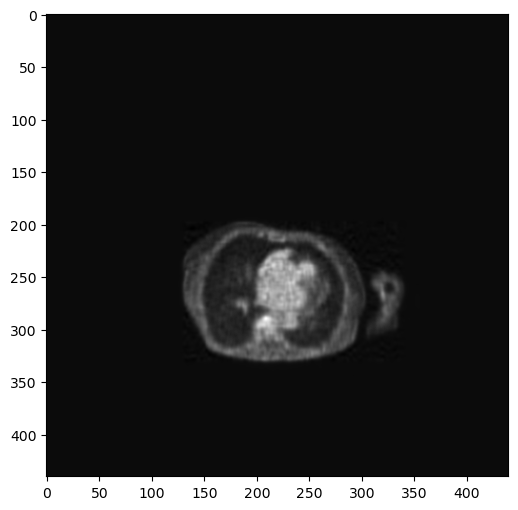

In [30]:
u, s, v = np.linalg.svd(noisy_img, full_matrices=False)

comps = [3648, 1, 5, 10, 15, 20]
plt.figure(figsize=(12, 6))
print(noisy_img.shape)
#for i in range(len(comps)):
low_rank = u[:, :20] @ np.diag(s[:20]) @ v[:20, :]
plt.imshow(low_rank, cmap='gray')



In [84]:
all_images=glob.glob('/Users/randyllpandohie/Downloads/testing/*.nii.gz')

print(all_images)

test_image=nib.load(all_images[0]).get_fdata()

new_image=nib.load(all_images[1]).get_fdata()

TV_cleaned_psnr = peak_signal_noise_ratio(test_image, new_image, data_range=1.0)
mse_tv = mean_squared_error(test_image, new_image)
(score, diff) = structural_similarity(test_image, new_image, full=True)

print(TV_cleaned_psnr)

['/Users/randyllpandohie/Downloads/testing/DRF_100.nii.gz', '/Users/randyllpandohie/Downloads/testing/new_improved.nii.gz']


ValueError: Found array with dim 3. None expected <= 2.

In [3]:
all_images=glob.glob('/Users/randyllpandohie/Downloads/testing/*.nii.gz')

print(all_images)

test_image=nib.load(all_images[3]).get_data()

['/Users/randyllpandohie/Downloads/testing/DRF_100.nii.gz', '/Users/randyllpandohie/Downloads/testing/newnewnewDRF_100.nii.gz', '/Users/randyllpandohie/Downloads/testing/new_improved.nii.gz']


NameError: name 'nib' is not defined